# EXPERIMENT 1
---
### Model Architecture: biDirectional LSTM
### Dataset: Milan

### Parameters
- INPUT_DIM = 1000 (chosen arbitary, high dimension)
- N_HIDDEN = 64
- MAX_LENGTH = 2000 (fixed)
- NO_ACTIVITIES = 8 (cairo fixed)
- OPTIMIZER = ADAM
- TOTAL EPOCHS = 25


In [1]:
from google.colab import drive
drive.mount('/content/drive/')
#imports
import os 
import pickle
import json
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

#tensorflow
import tensorflow as tf
from keras.layers import Dense, LSTM, Bidirectional, RNN
from keras.layers.embeddings import Embedding
from keras.models import Sequential
DATA_PATH = '/content/drive/My Drive/Research/Deeplearning-in-IoT-systems/PP_Data/'

Mounted at /content/drive/


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def getData(datasetName):
    X = np.load(f"{DATA_PATH}{datasetName}_X.npy", allow_pickle=True)
    Y = np.load(f"{DATA_PATH}{datasetName}_Y.npy", allow_pickle=True)
    enc_dec = np.load(f"{DATA_PATH}/{datasetName}_ENCDEC.npy", allow_pickle=True)
    return X, Y, enc_dec
X, y, (idx2act, idx2obs, act2idx, obs2idx) = getData('milan')

In [8]:
def get_class_acc(X, y, model, idx2act):
  preds = np.array(np.argmax(model.predict(X, verbose=1), axis=-1), dtype=np.int32)
  targets = np.array(y, dtype=np.int32)
  
  print("Classwise accuracy: ")
  totals = {}
  correct = {}
  for i in range(len(idx2act)):
    totals[i] = 1
    correct[i] = 0
  for each in targets: 
    totals[each]+=1
  for i in range(len(idx2act)):
    if totals[i] != 1:
      totals[i] -= 1
  for i, each in enumerate(preds): 
    if each == targets[i]:
        correct[each]+=1
  for i, each in enumerate(idx2act):
    print(f"Model accuracy for predicting {each}: {correct[i]}/{totals[i]} || {round(correct[i]/totals[i]*100, 2)}%")

  print('-'*120)
  m = confusion_matrix(targets, preds)
  fig, ax = plt.subplots(figsize=(23,20))
  sns.heatmap(m, annot=True, ax=ax)
  ax.set(xticklabels=idx2act, yticklabels=idx2act)
  plt.show()
  print('-'*120)

In [3]:
def plot_history(dict):
  # summarize history for accuracy
  plt.figure(figsize=(10,10))
  plt.plot(dict['accuracy'])
  plt.plot(dict['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(10,10))
  plt.plot(dict['loss'])
  plt.plot(dict['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()

In [10]:
def run(X, y, idx2act, model, save_as, EPOCHS=10):
  print("-"*100)
  print(" > REPORT")
  print("-"*100)
  # TEST SPLIT
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1)

  print('Training set distribution')
  fig, ax = plt.subplots(figsize=(20,5))
  train_y_df = pd.DataFrame({'y' : np.array(y_train, dtype=np.float32)})
  sns.countplot(train_y_df.y, ax=ax)
  ax.set(xticklabels=idx2act)
  plt.xticks(rotation=45)
  plt.show()
  print('Test set distribution')
  fig2, ax2 = plt.subplots(figsize=(20,5))
  test_y_df = pd.DataFrame({'y' : np.array(y_test, dtype=np.float32)})
  sns.countplot(test_y_df.y, ax=ax2)
  ax2.set(xticklabels=idx2act)
  plt.xticks(rotation=45)
  plt.show()
  
  print('Activity accuracy training set')
  print('-'*80)
  get_class_acc(tf.convert_to_tensor(np.array(X_train, dtype=np.float32)), tf.convert_to_tensor(np.array(y_train, dtype=np.float32)), model, idx2act)
  print()
  print('Activity accuracy test set')
  print('-'*80)
  get_class_acc(tf.convert_to_tensor(np.array(X_test, dtype=np.float32)), tf.convert_to_tensor(np.array(y_test, dtype=np.float32)), model, idx2act)
  
  # KFOLD SETUP
  X_train_np = np.array(X_train, dtype=np.float32)
  y_train_np = np.array(y_train, dtype=np.float32)
  skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
  # KFOLD LOOP
  overall_acc = []
  
  agg_hist={'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
  for i, (train, test) in enumerate(skf.split(X_train_np, y_train_np)):
    print(f'Fold >> {i+1}')
    X_train_ = tf.convert_to_tensor(X_train_np[train], dtype=tf.float32)
    Y_train_ = tf.convert_to_tensor(y_train_np[train], dtype=tf.float32)
    X_test_ = tf.convert_to_tensor(X_train_np[test], dtype=tf.float32)
    Y_test_ = tf.convert_to_tensor(y_train_np[test], dtype=tf.float32)
    print(f"Begin training ...")

    filepath = f"/content/drive/My Drive/Research/Deeplearning-in-IoT-systems/Experiments/Models/{save_as}"
    history = model.fit(X_train_, Y_train_, epochs=EPOCHS, batch_size=64, verbose=1, callbacks=[], validation_split=0.2)
    agg_hist['loss'].extend(history.history['loss'])
    agg_hist['val_loss'].extend(history.history['val_loss'])
    agg_hist['accuracy'].extend(history.history['accuracy'])
    agg_hist['val_accuracy'].extend(history.history['val_accuracy'])
    print(f"Begin evalutaion ...")
    scores = model.evaluate(X_test_, Y_test_, batch_size=64, verbose=1)
    print('%s: %.2f%%' % (model.metrics_names[1], scores[1] * 100))
    overall_acc.append(scores[1]*100)
    print()

  model.save(filepath+".h5")
  print('HISTORY')
  plot_history(agg_hist)
  print()

  print('Test set evalutaion')
  scores = model.evaluate(tf.convert_to_tensor(np.array(X_test, dtype=np.float32)), tf.convert_to_tensor(np.array(y_test, dtype=np.float32)), batch_size=64, verbose=1)
  print('%s: %.2f%%' % (model.metrics_names[1], scores[1] * 100))
  print()
  print('Activity accuracy training set')
  print('-'*80)
  get_class_acc(tf.convert_to_tensor(np.array(X_train, dtype=np.float32)), tf.convert_to_tensor(np.array(y_train, dtype=np.float32)), model, idx2act)
  print()
  print('Activity accuracy test set')
  print('-'*80)
  get_class_acc(tf.convert_to_tensor(np.array(X_test, dtype=np.float32)), tf.convert_to_tensor(np.array(y_test, dtype=np.float32)), model, idx2act)

In [4]:
# biLSTM 
def get_biLSTM(INPUT_DIM, N_HIDDEN, MAX_LENGTH, NO_ACTIVITIES, OPTIMIZER):
  model = Sequential(name='biLSTM')
  model.add(Embedding(INPUT_DIM, N_HIDDEN, input_length=MAX_LENGTH, mask_zero=True))
  model.add(Bidirectional(LSTM(N_HIDDEN)))
  model.add(Dense(NO_ACTIVITIES, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
  model.summary()
  return model

In [5]:
#Arbitary high dim
INPUT_DIM = 1000 
#2n
N_HIDDEN = 64
MAX_LENGTH = 2000
NO_ACTIVITIES = len(idx2act)
OPTIMIZER = 'adam'

In [6]:
model = get_biLSTM(INPUT_DIM, N_HIDDEN, MAX_LENGTH, NO_ACTIVITIES, OPTIMIZER)

Model: "biLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 14)                1806      
Total params: 131,854
Trainable params: 131,854
Non-trainable params: 0
_________________________________________________________________


----------------------------------------------------------------------------------------------------
 > REPORT
----------------------------------------------------------------------------------------------------
Training set distribution


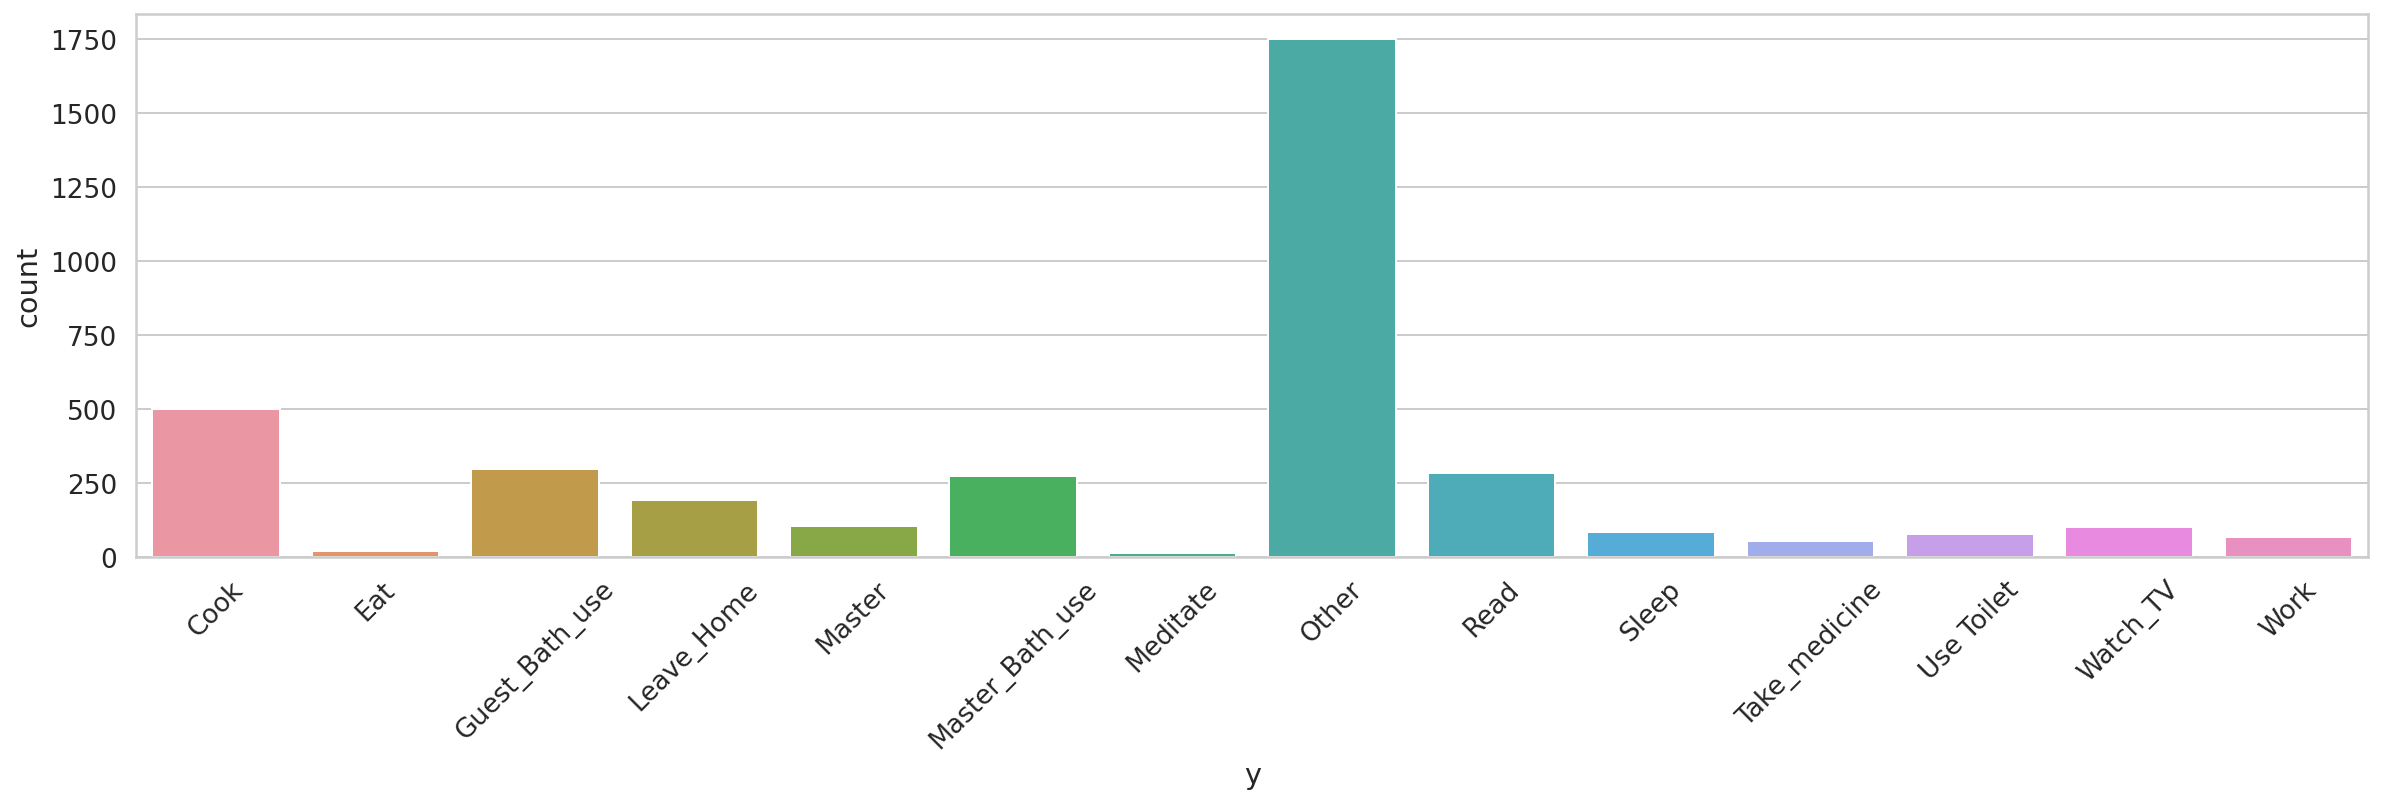

Test set distribution


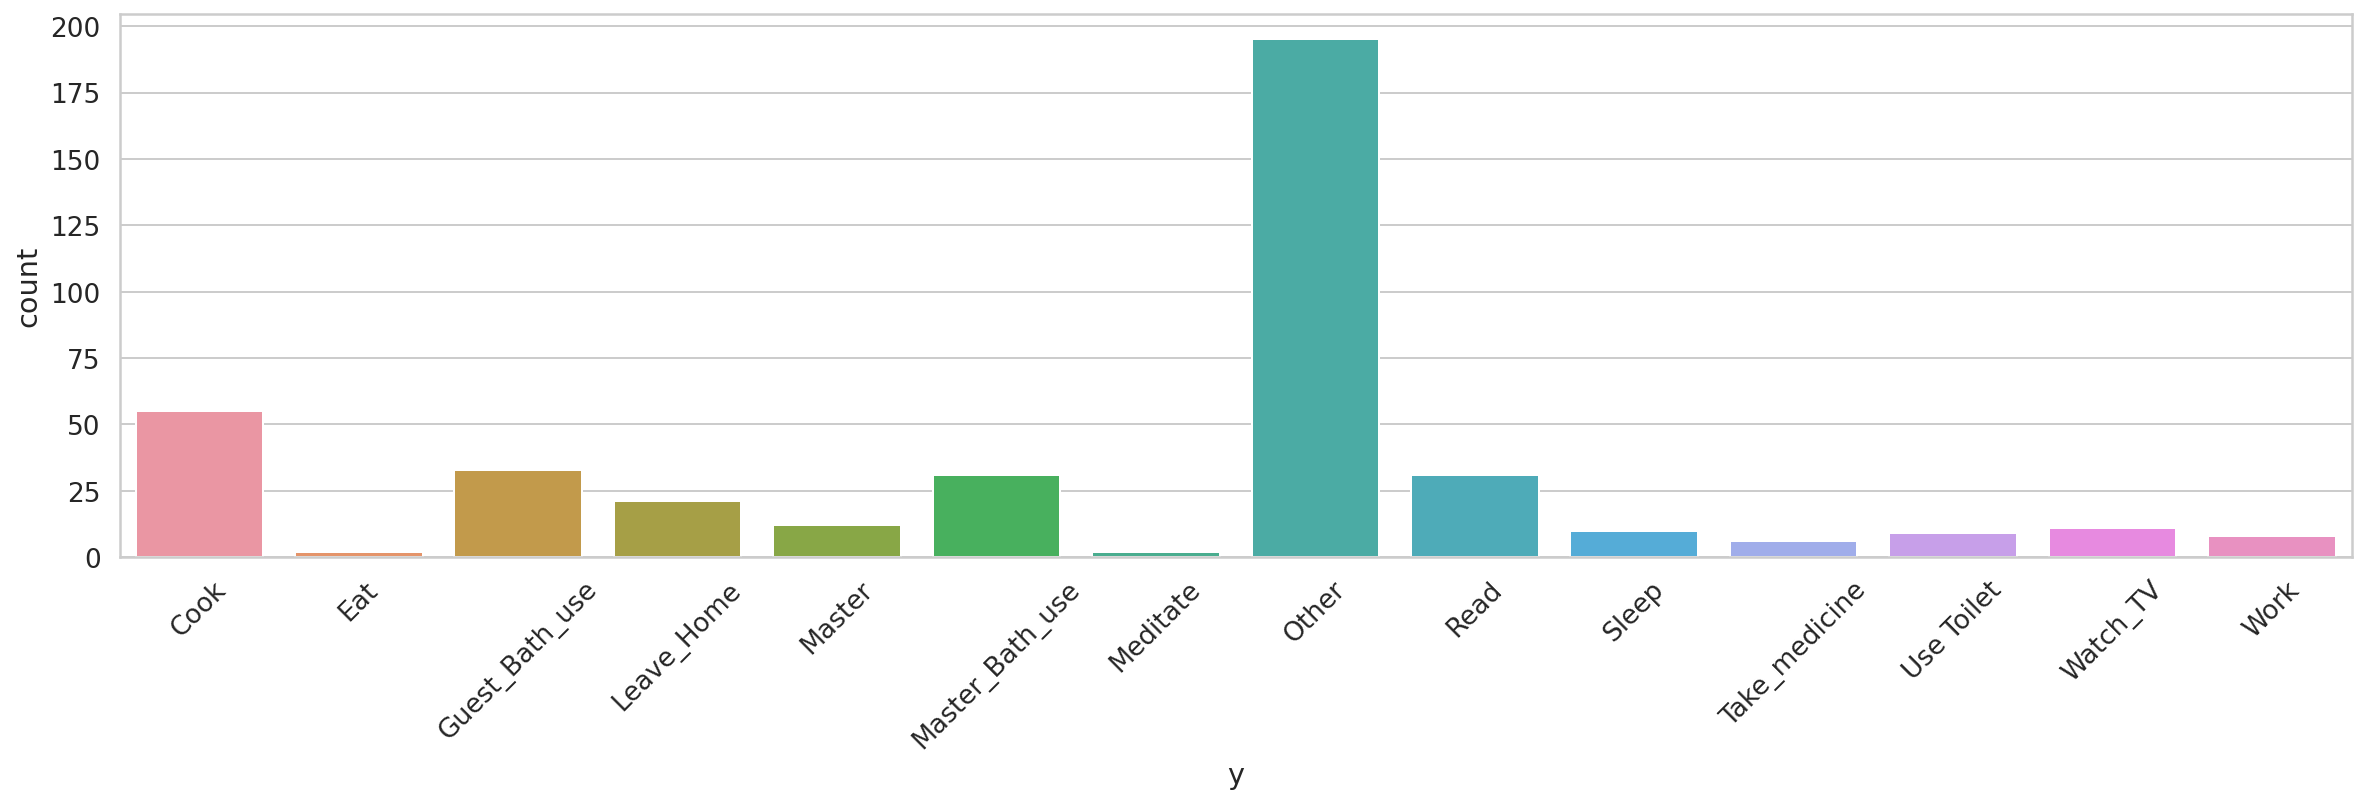

Activity accuracy training set
--------------------------------------------------------------------------------
120/120 [==============================] - 120s 1s/step
Classwise accuracy: 
Model accuracy for predicting Cook: 0/499 || 0.0%
Model accuracy for predicting Eat: 0/20 || 0.0%
Model accuracy for predicting Guest_Bath_use: 34/297 || 11.45%
Model accuracy for predicting Leave_Home: 0/193 || 0.0%
Model accuracy for predicting Master: 4/105 || 3.81%
Model accuracy for predicting Master_Bath_use: 7/275 || 2.55%
Model accuracy for predicting Meditate: 0/15 || 0.0%
Model accuracy for predicting Other: 161/1748 || 9.21%
Model accuracy for predicting Read: 0/283 || 0.0%
Model accuracy for predicting Sleep: 0/86 || 0.0%
Model accuracy for predicting Take_medicine: 0/54 || 0.0%
Model accuracy for predicting Use Toilet: 2/80 || 2.5%
Model accuracy for predicting Watch_TV: 9/103 || 8.74%
Model accuracy for predicting Work: 4/68 || 5.88%
-----------------------------------------------------

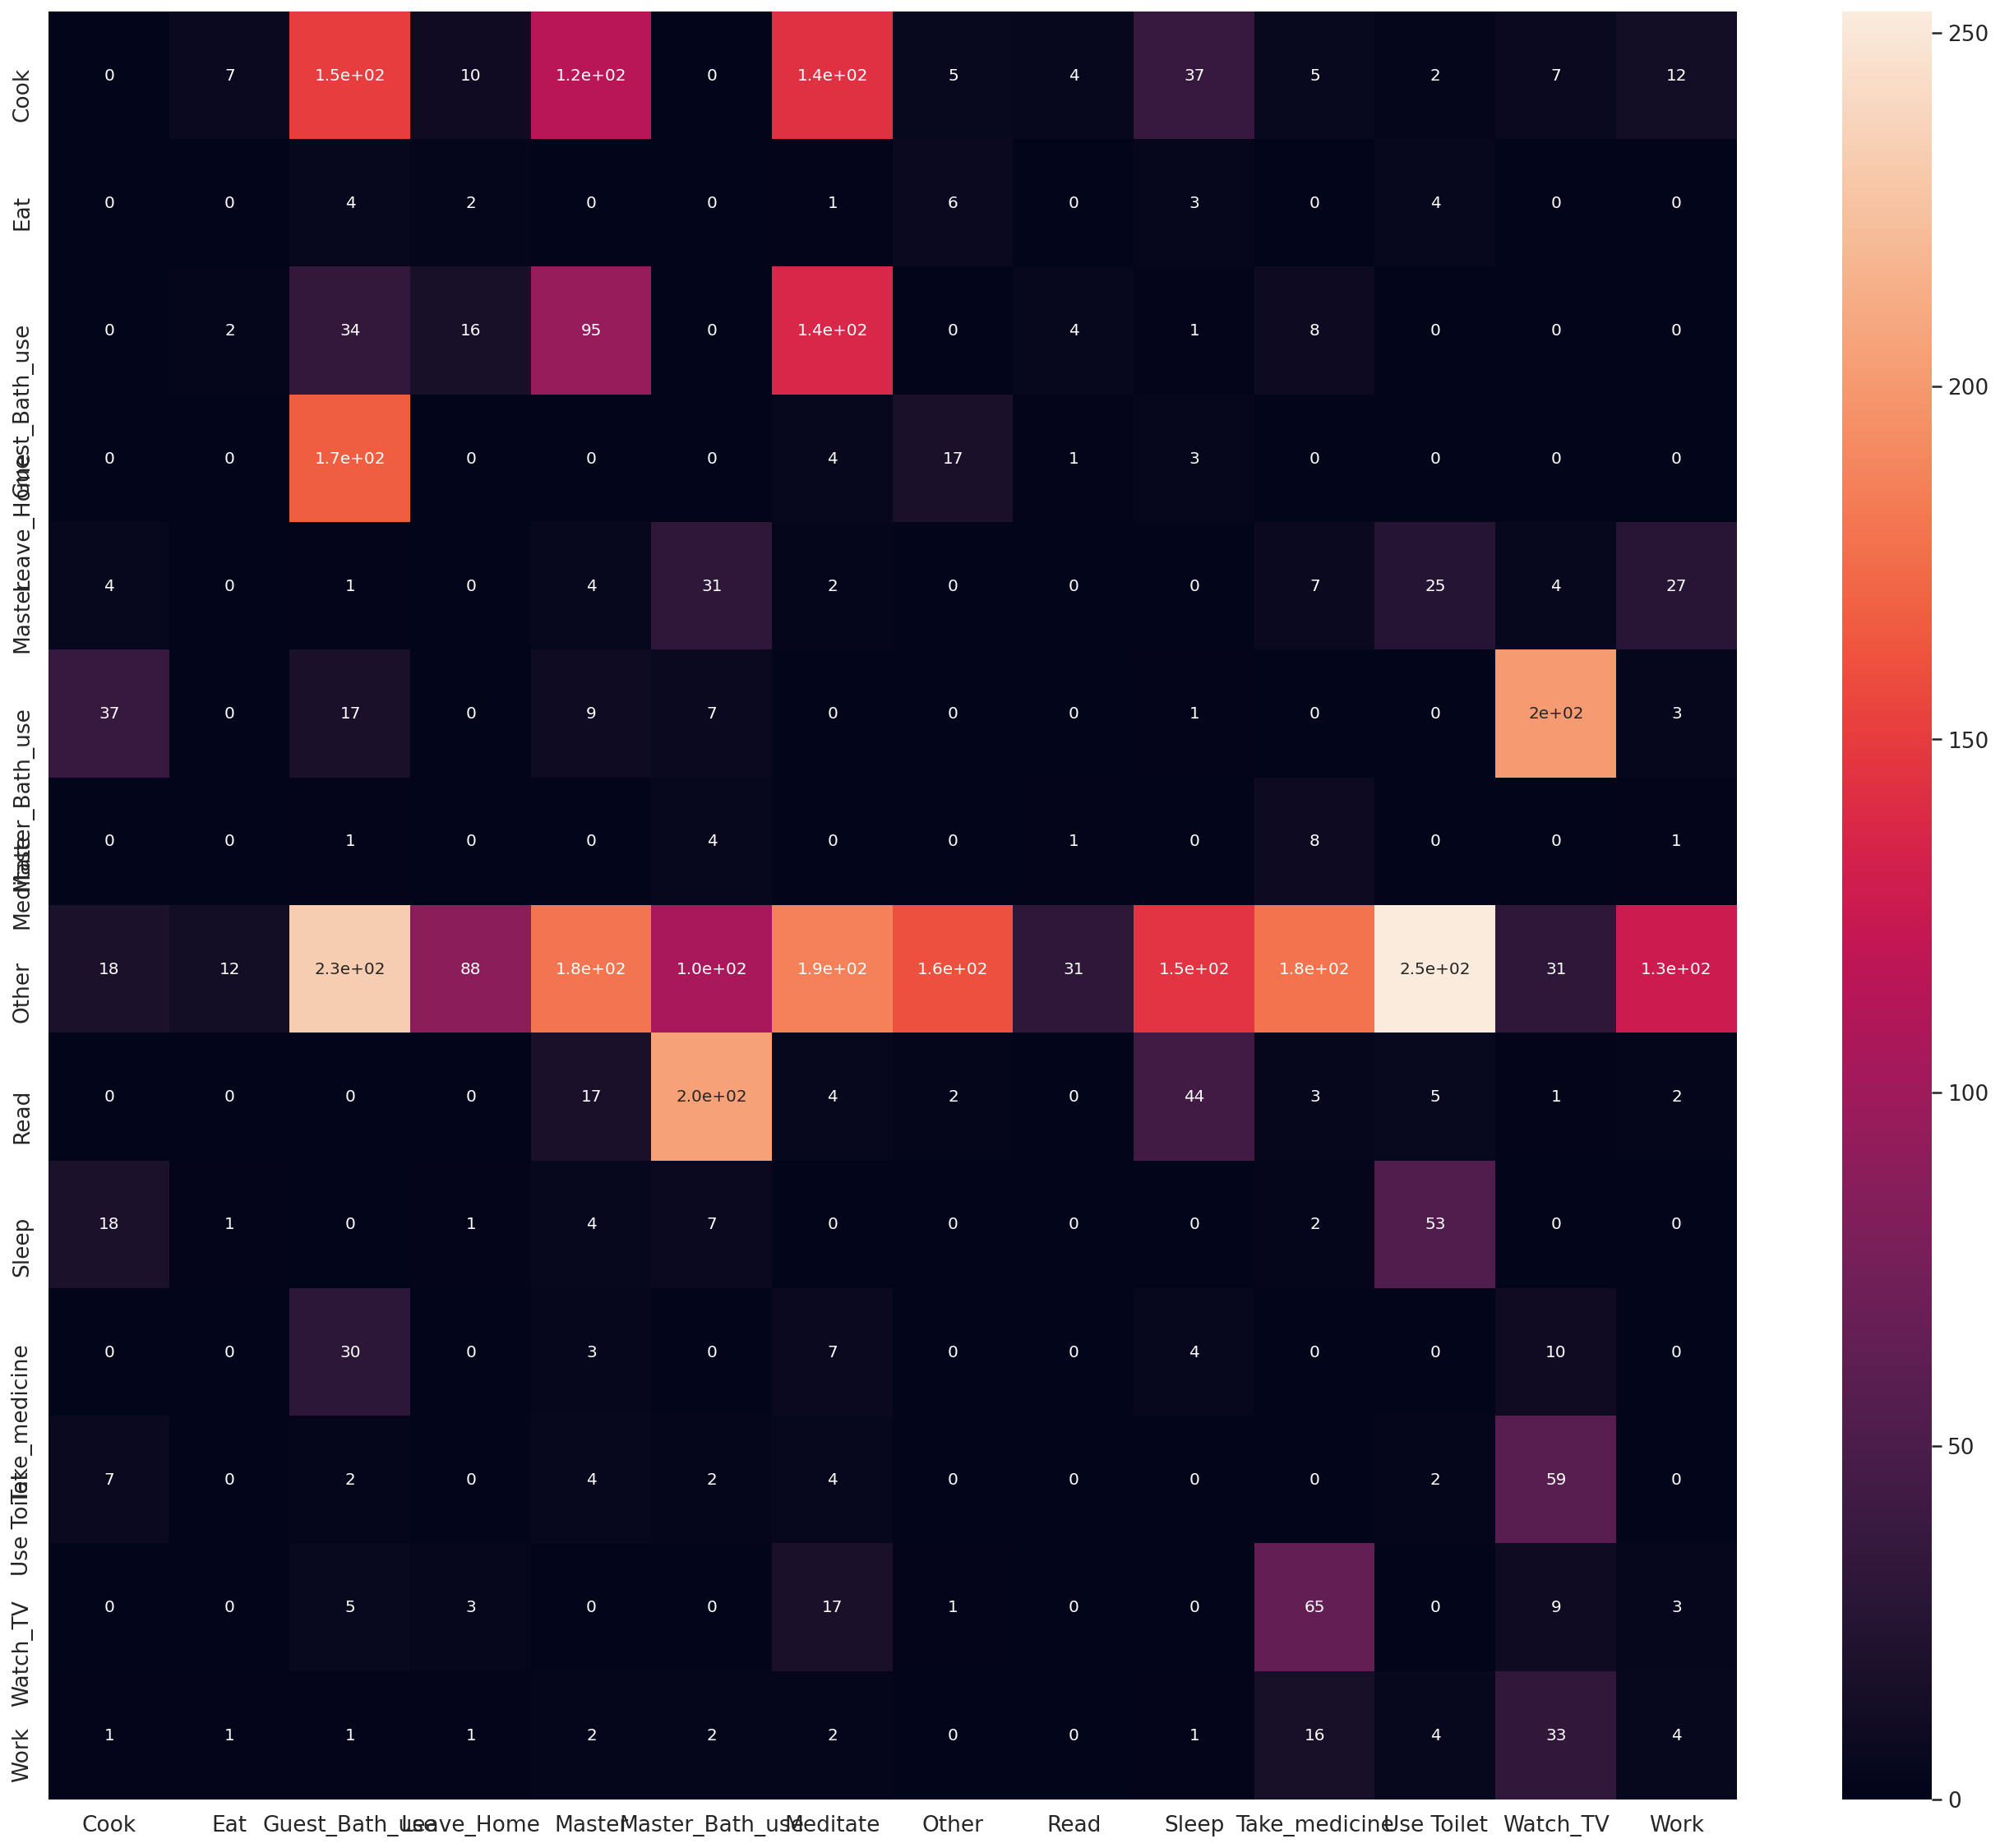

------------------------------------------------------------------------------------------------------------------------

Activity accuracy test set
--------------------------------------------------------------------------------
14/14 [==============================] - 13s 927ms/step
Classwise accuracy: 
Model accuracy for predicting Cook: 0/55 || 0.0%
Model accuracy for predicting Eat: 0/2 || 0.0%
Model accuracy for predicting Guest_Bath_use: 6/33 || 18.18%
Model accuracy for predicting Leave_Home: 0/21 || 0.0%
Model accuracy for predicting Master: 0/12 || 0.0%
Model accuracy for predicting Master_Bath_use: 0/31 || 0.0%
Model accuracy for predicting Meditate: 0/2 || 0.0%
Model accuracy for predicting Other: 9/195 || 4.62%
Model accuracy for predicting Read: 0/31 || 0.0%
Model accuracy for predicting Sleep: 0/10 || 0.0%
Model accuracy for predicting Take_medicine: 0/6 || 0.0%
Model accuracy for predicting Use Toilet: 0/9 || 0.0%
Model accuracy for predicting Watch_TV: 2/11 || 18.18%
M

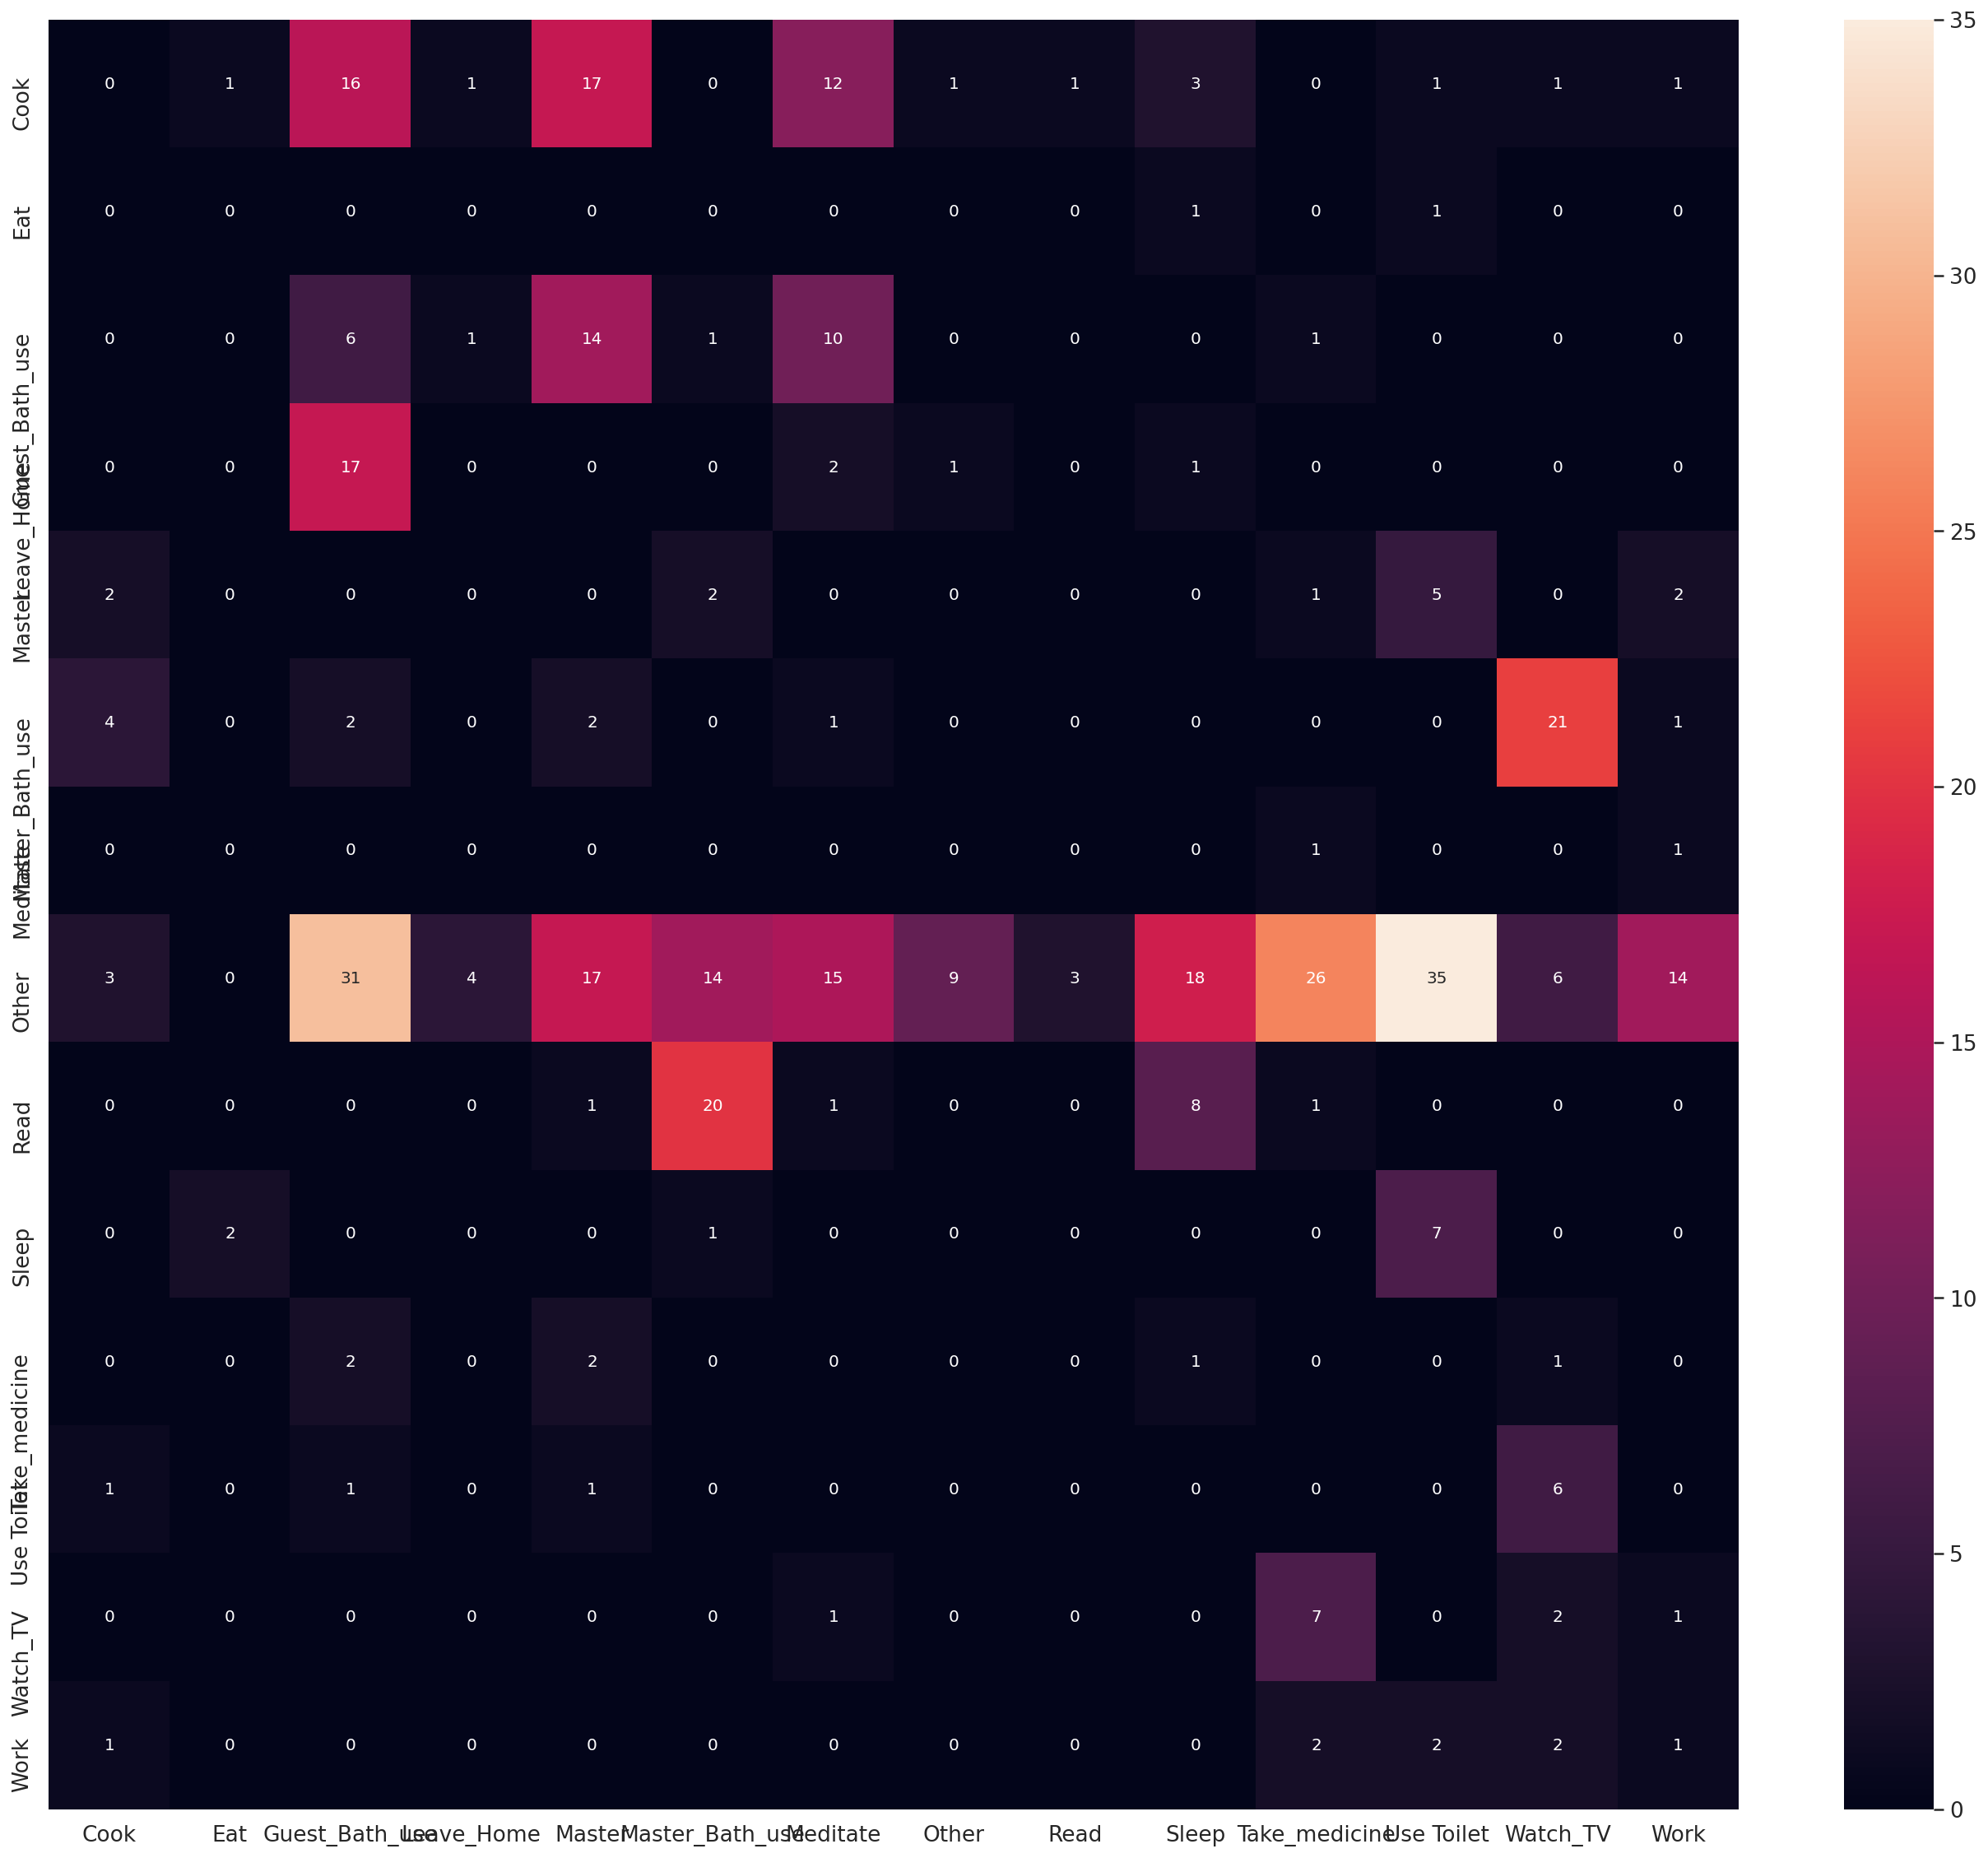

------------------------------------------------------------------------------------------------------------------------
Fold >> 1
Begin training ...
Epoch 1/5
39/39 [==============================] - 342s 9s/step - loss: 2.1009 - accuracy: 0.4971 - val_loss: 1.5276 - val_accuracy: 0.6699
Epoch 2/5
39/39 [==============================] - 340s 9s/step - loss: 1.1517 - accuracy: 0.7067 - val_loss: 0.8553 - val_accuracy: 0.7843
Epoch 3/5
39/39 [==============================] - 339s 9s/step - loss: 0.7505 - accuracy: 0.7982 - val_loss: 0.6219 - val_accuracy: 0.8105
Epoch 4/5
39/39 [==============================] - 338s 9s/step - loss: 0.5741 - accuracy: 0.8382 - val_loss: 0.4986 - val_accuracy: 0.8676
Epoch 5/5
39/39 [==============================] - 340s 9s/step - loss: 0.4853 - accuracy: 0.8619 - val_loss: 0.4399 - val_accuracy: 0.8791
Begin evalutaion ...
12/12 [==============================] - 11s 913ms/step - loss: 0.4904 - accuracy: 0.8695
accuracy: 86.95%

Fold >> 2
Begin train

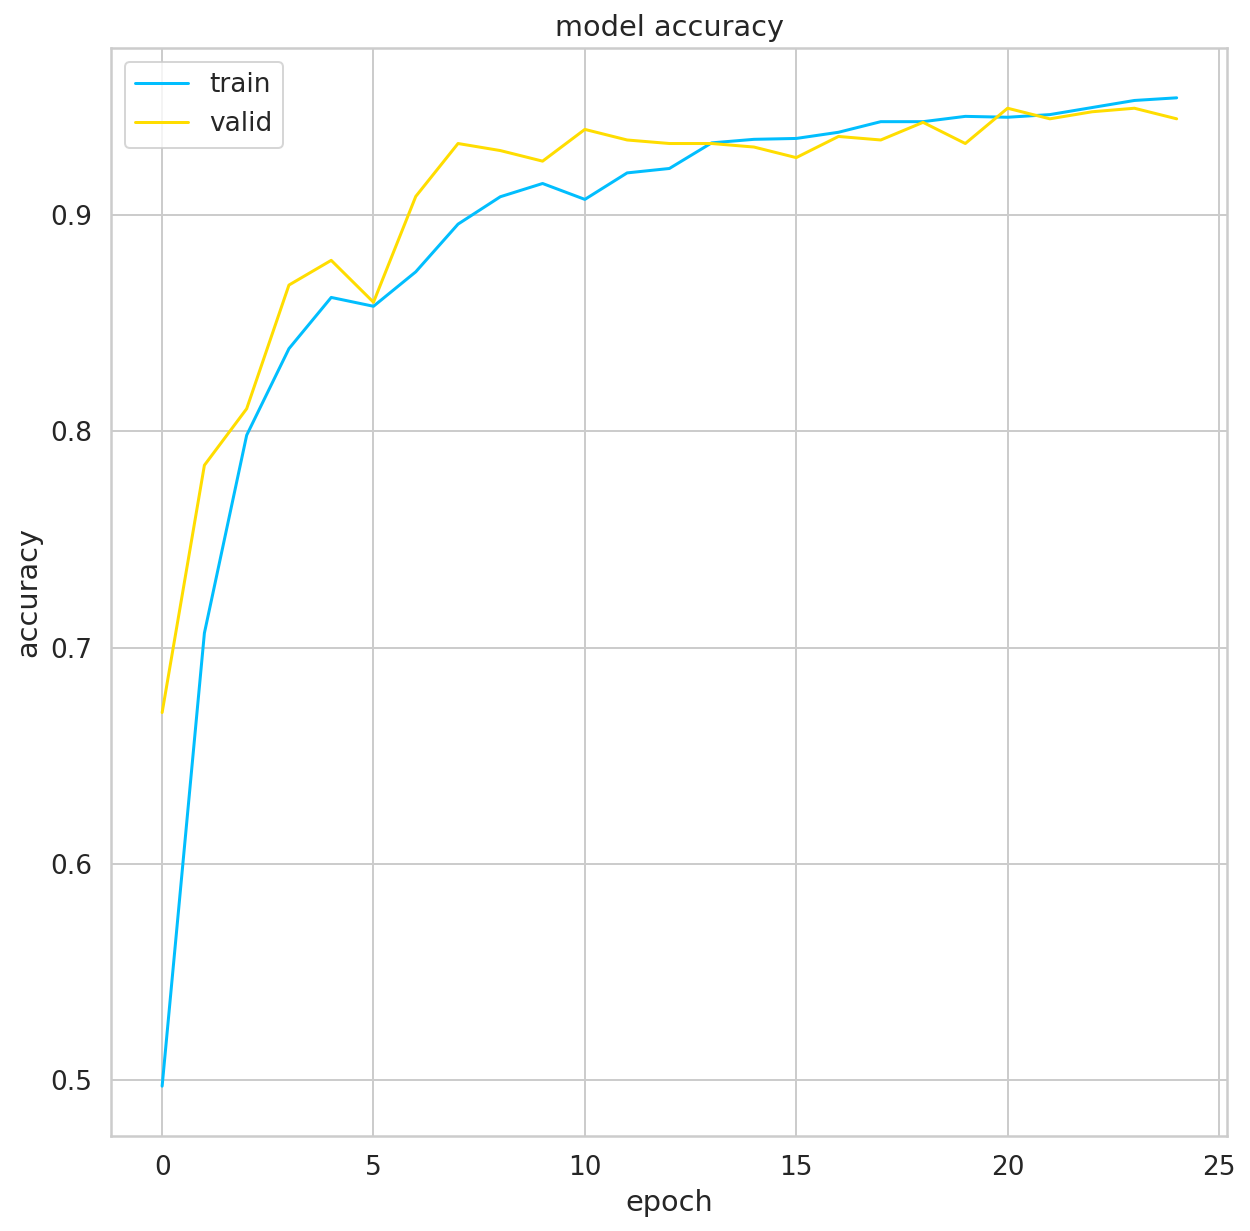

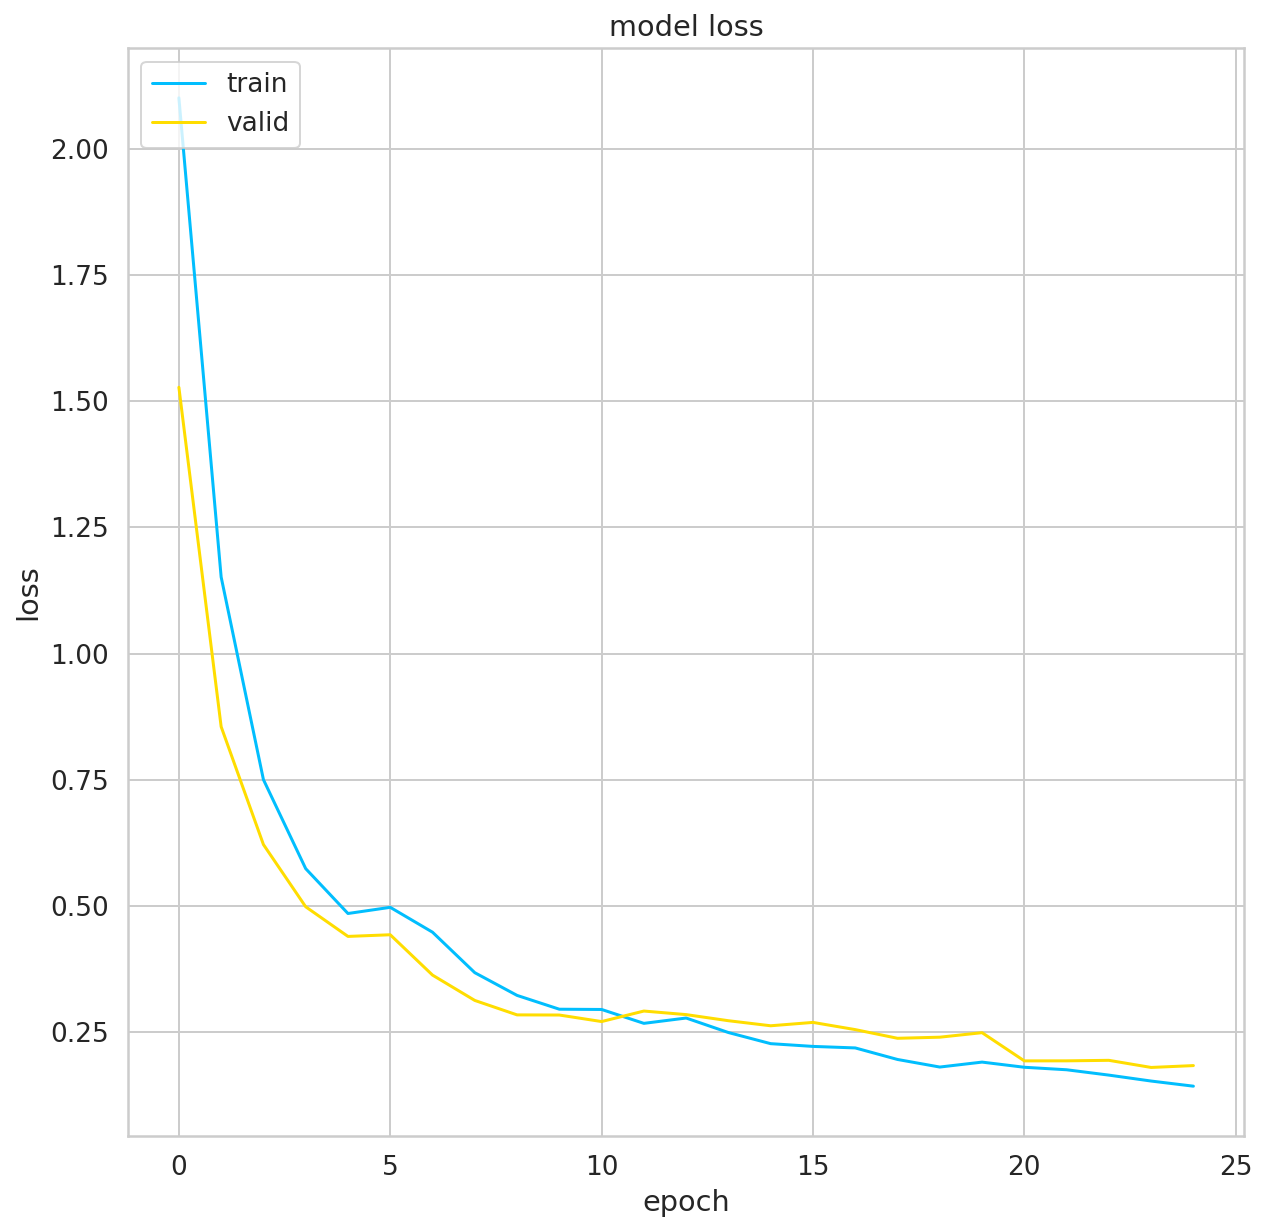


Test set evalutaion
7/7 [==============================] - 6s 854ms/step - loss: 0.2043 - accuracy: 0.9484
accuracy: 94.84%

Activity accuracy training set
--------------------------------------------------------------------------------
120/120 [==============================] - 122s 1s/step
Classwise accuracy: 
Model accuracy for predicting Cook: 489/499 || 98.0%
Model accuracy for predicting Eat: 0/20 || 0.0%
Model accuracy for predicting Guest_Bath_use: 295/297 || 99.33%
Model accuracy for predicting Leave_Home: 190/193 || 98.45%
Model accuracy for predicting Master: 99/105 || 94.29%
Model accuracy for predicting Master_Bath_use: 258/275 || 93.82%
Model accuracy for predicting Meditate: 15/15 || 100.0%
Model accuracy for predicting Other: 1696/1748 || 97.03%
Model accuracy for predicting Read: 283/283 || 100.0%
Model accuracy for predicting Sleep: 84/86 || 97.67%
Model accuracy for predicting Take_medicine: 49/54 || 90.74%
Model accuracy for predicting Use Toilet: 38/80 || 47.5%
Mo

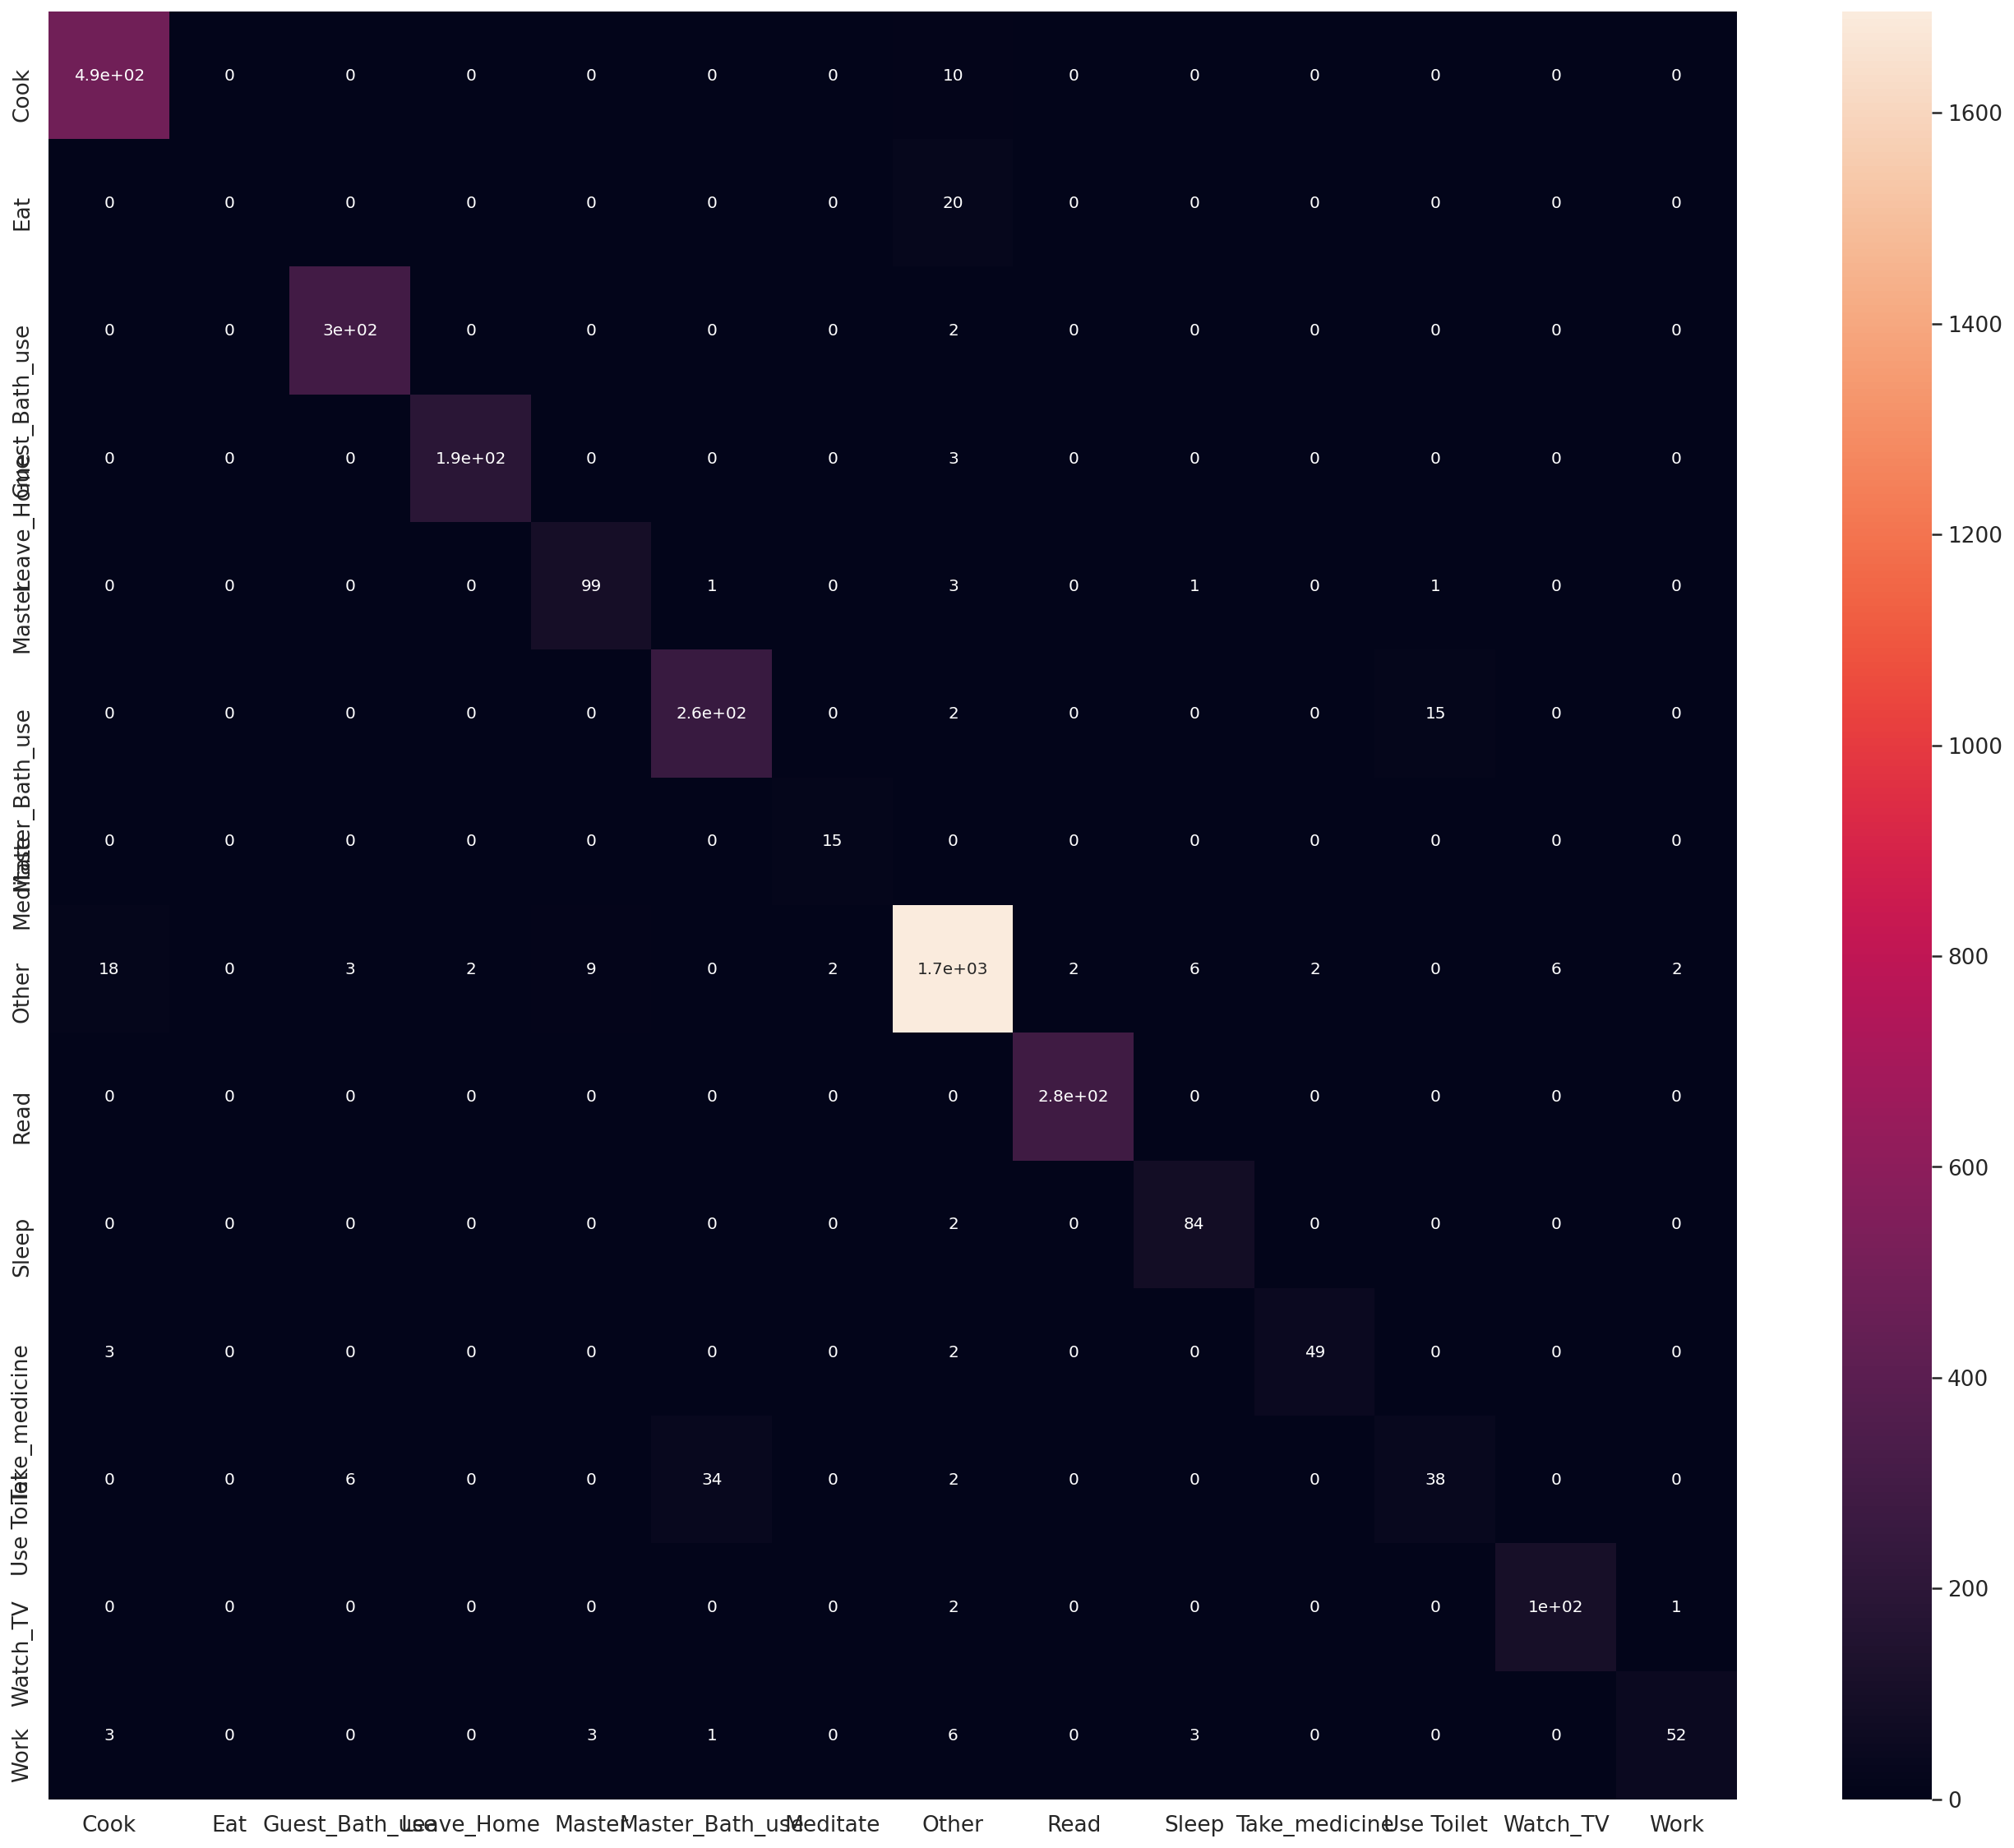

------------------------------------------------------------------------------------------------------------------------

Activity accuracy test set
--------------------------------------------------------------------------------
14/14 [==============================] - 13s 961ms/step
Classwise accuracy: 
Model accuracy for predicting Cook: 55/55 || 100.0%
Model accuracy for predicting Eat: 0/2 || 0.0%
Model accuracy for predicting Guest_Bath_use: 33/33 || 100.0%
Model accuracy for predicting Leave_Home: 20/21 || 95.24%
Model accuracy for predicting Master: 11/12 || 91.67%
Model accuracy for predicting Master_Bath_use: 28/31 || 90.32%
Model accuracy for predicting Meditate: 2/2 || 100.0%
Model accuracy for predicting Other: 188/195 || 96.41%
Model accuracy for predicting Read: 31/31 || 100.0%
Model accuracy for predicting Sleep: 10/10 || 100.0%
Model accuracy for predicting Take_medicine: 4/6 || 66.67%
Model accuracy for predicting Use Toilet: 7/9 || 77.78%
Model accuracy for predictin

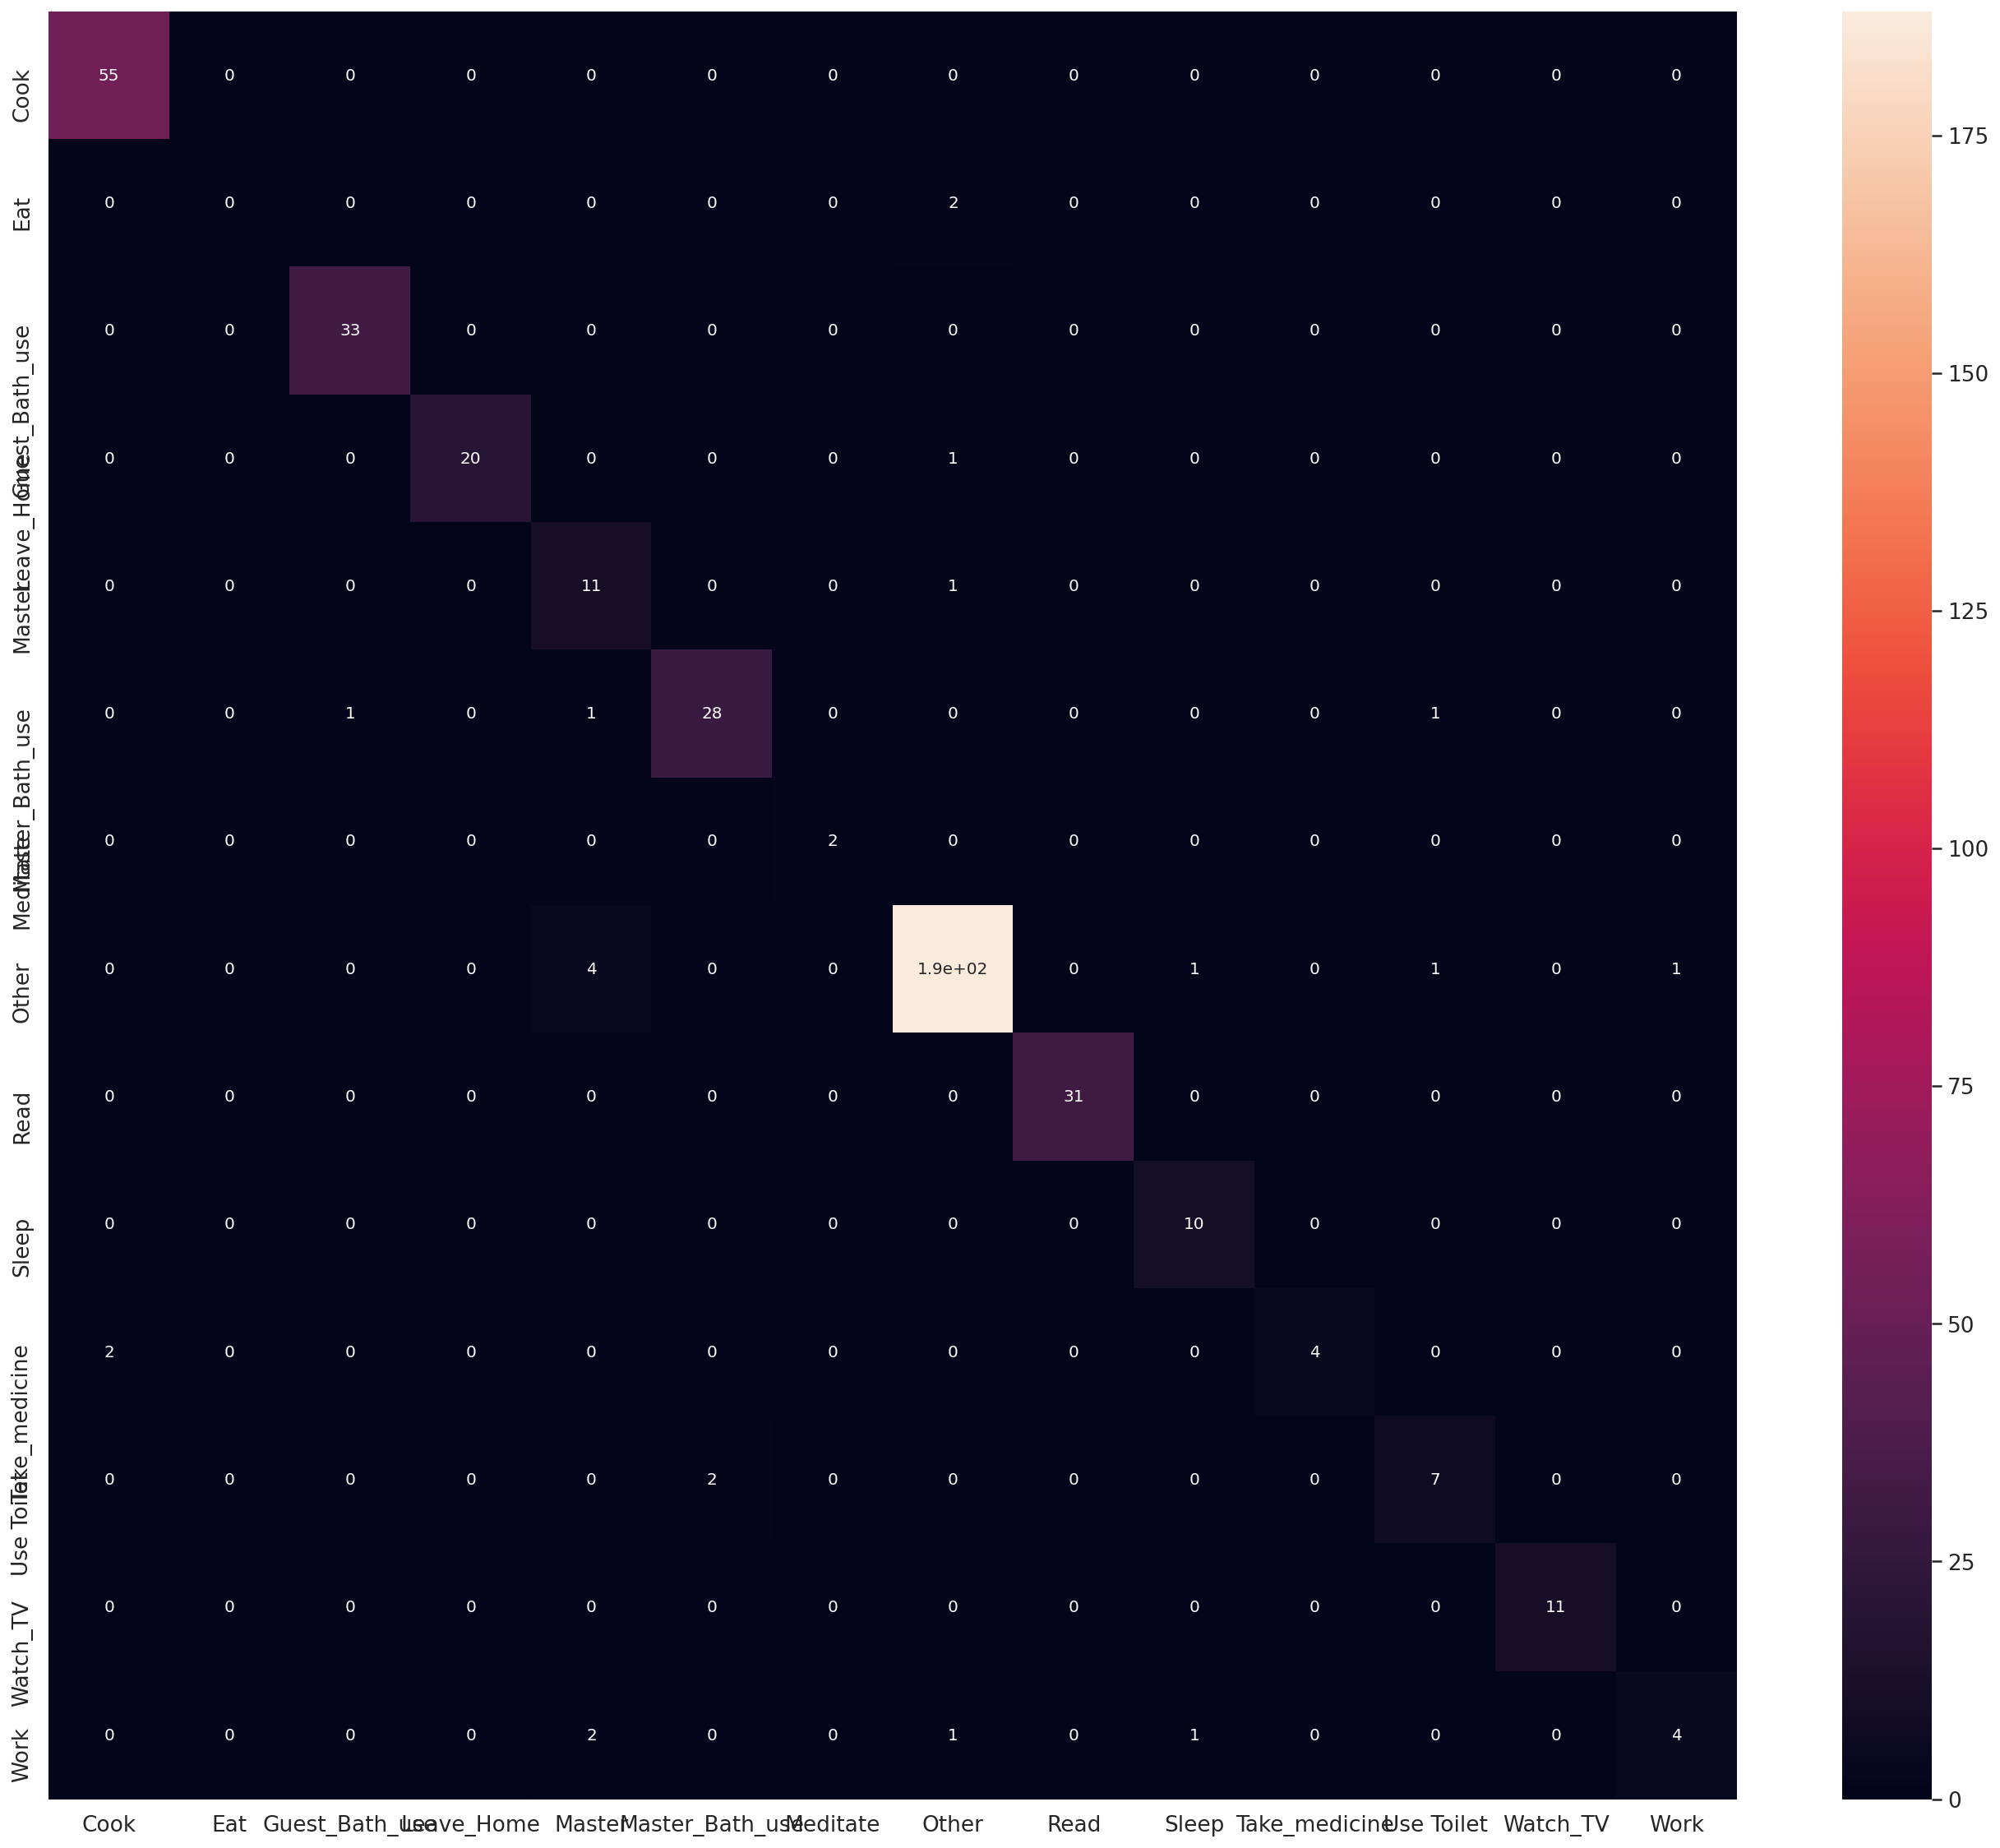

------------------------------------------------------------------------------------------------------------------------


In [11]:
#GO
run(X, y, idx2act, model, 'biLSTM_EP1', 5)